# Comprehensive Comparison: Gaussian vs. Skewed vs. Fat-Tailed Distributions

## 1. Objective
This notebook provides a comparative analysis of Value at Risk (VaR) estimation across three distinct market regimes modeled by different probability distributions:
1.  **Gaussian (Normal)**: Standard assumption, often underestimates tail risk.
2.  **Skewed (Negative Skew)**: Represents asymmetric downside risk (e.g., market crashes).
3.  **Fat-Tailed (High Kurtosis)**: Represents extreme events (black swans) using Student's t-distribution.

We compare three methods:
*   **IQAE Estimated VaR**: Quantum Amplitude Estimation.
*   **Classical Monte Carlo (MC)**: Standard simulation with 100,000 samples.
*   **Theoretical VaR**: Exact analytical value (ground truth).

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from classiq import *
from classiq.applications.iqae.iqae import IQAE

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-pastel')
print("Environment initialized.")

Environment initialized.


## 2. Defining the "Regimes"
We define three representative distributions with the same Mean and Volatility (roughly) to isolate the shape effects.

In [95]:
# Global Parameters
N = 128
num_qubits = int(np.log2(N))
ALPHA_VAR = 0.05
CALIBRATION_EPSILON = 0.01

mu = 0.15
sigma = 0.20

# 1. Gaussian
dist_gaussian = stats.norm(loc=mu, scale=sigma)

# 2. Skewed (Positive Skew, e.g. 3)
skew_param = 1
dist_skewed = stats.skewnorm(skew_param, loc=mu - 0.5, scale=sigma) # Shift loc to align peaks roughly for visual

# 3. Fat Tailed (Student's t, df=3)
df_param = 0.85
dist_kurtotic = stats.t(df_param, loc=mu, scale=sigma)

regimes = {
    'Gaussian': dist_gaussian,
    'Skewed (Neg)': dist_skewed,
    'Fat-Tailed (t-dist)': dist_kurtotic
}
colors = {'Gaussian': 'gray', 'Skewed (Neg)': 'red', 'Fat-Tailed (t-dist)': 'orange'}

# Common grid
grid_min = -2.0
grid_max = 2.0
grid_points = np.linspace(grid_min, grid_max, N)
dx = (grid_max - grid_min) / N

## 3. Visual Comparison of Tails

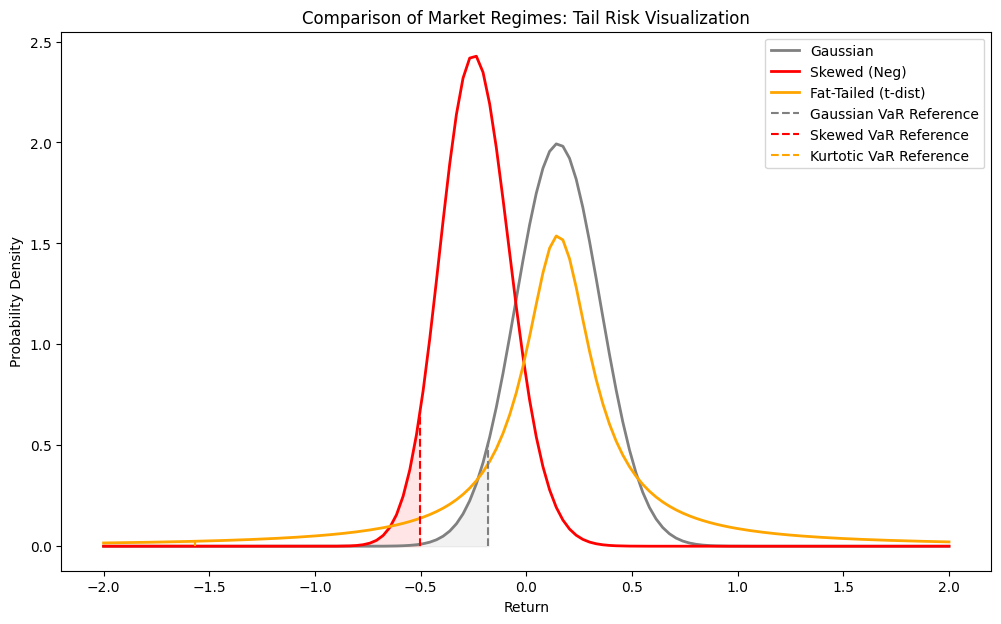

In [96]:
plt.figure(figsize=(12, 7))

for name, dist in regimes.items():
    pdf = dist.pdf(grid_points)
    plt.plot(grid_points, pdf, label=name, color=colors[name], lw=2)
    # Shade the 5% tail area for each (theoretical)
    cutoff = dist.ppf(0.05)
    tail_x = np.linspace(grid_min, cutoff, 100)
    tail_y = dist.pdf(tail_x)
    plt.fill_between(tail_x, 0, tail_y, color=colors[name], alpha=0.1)

plt.vlines(dist_gaussian.ppf(0.05), 0, dist_gaussian.pdf(dist_gaussian.ppf(0.05)), color='gray', linestyle='--', label='Gaussian VaR Reference')
plt.vlines(dist_skewed.ppf(0.05), 0, dist_skewed.pdf(dist_skewed.ppf(0.05)), color='red', linestyle='--', label='Skewed VaR Reference')
plt.vlines(dist_kurtotic.ppf(0.05), 0, dist_kurtotic.pdf(dist_kurtotic.ppf(0.05)), color='orange', linestyle='--', label='Kurtotic VaR Reference')

plt.title("Comparison of Market Regimes: Tail Risk Visualization")
plt.xlabel("Return")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

## 4. Estmation Loop (Quantum + Classical MC)
We calculate the 95% VaR for all three regimes using IQAE and Classical Monte Carlo.

In [97]:
# Construct shared quantum functions (same pattern as before)
CURRENT_PROBS = []
THRESHOLD_IDX = 0

@qfunc
def load_fin_distribution(asset: QNum):
    inplace_prepare_state(CURRENT_PROBS, bound=0, target=asset)

@qperm
def payoff_oracle(asset: Const[QNum], ind: QBit):
    ind ^= asset < THRESHOLD_IDX

@qfunc(synthesize_separately=True)
def full_model(asset: QNum, ind: QBit):
    load_fin_distribution(asset)
    payoff_oracle(asset, ind)

def get_iqae_var(dist, name):
    global CURRENT_PROBS, THRESHOLD_IDX
    
    # Discretize
    pdf = dist.pdf(grid_points)
    probs = pdf * dx
    probs /= np.sum(probs)
    CURRENT_PROBS = list(probs)
    
    # Classical seed
    cdf_arr = np.cumsum(probs)
    approx_idx = np.searchsorted(cdf_arr, ALPHA_VAR)
    THRESHOLD_IDX = int(approx_idx)
    
    # Run IQAE
    iqae = IQAE(
        state_prep_op=full_model,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=20),
    )
    result = iqae.run(epsilon=CALIBRATION_EPSILON, alpha=0.05)
    est_cdf = result.estimation
    
    return grid_points[approx_idx], est_cdf

def get_mc_var(dist, num_samples=100000):
    # Standard Monte Carlo: Sample -> Sort -> Percentile
    samples = dist.rvs(size=num_samples)
    # 5th percentile is the 95% worst loss (left tail)
    var_est = np.percentile(samples, 5)
    return var_est

results = {}
print("Running Comparison...")
for name, dist in regimes.items():
    print(f"Processing {name}...")
    # 1. IQAE
    var_iqae, prob = get_iqae_var(dist, name)
    # 2. Classical MC
    var_mc = get_mc_var(dist)
    # 3. Theory
    theory_var = dist.ppf(ALPHA_VAR)
    
    results[name] = (var_iqae, var_mc, theory_var)

Running Comparison...
Processing Gaussian...
Processing Skewed (Neg)...
Processing Fat-Tailed (t-dist)...


## 5. Comparative Results & Metrics

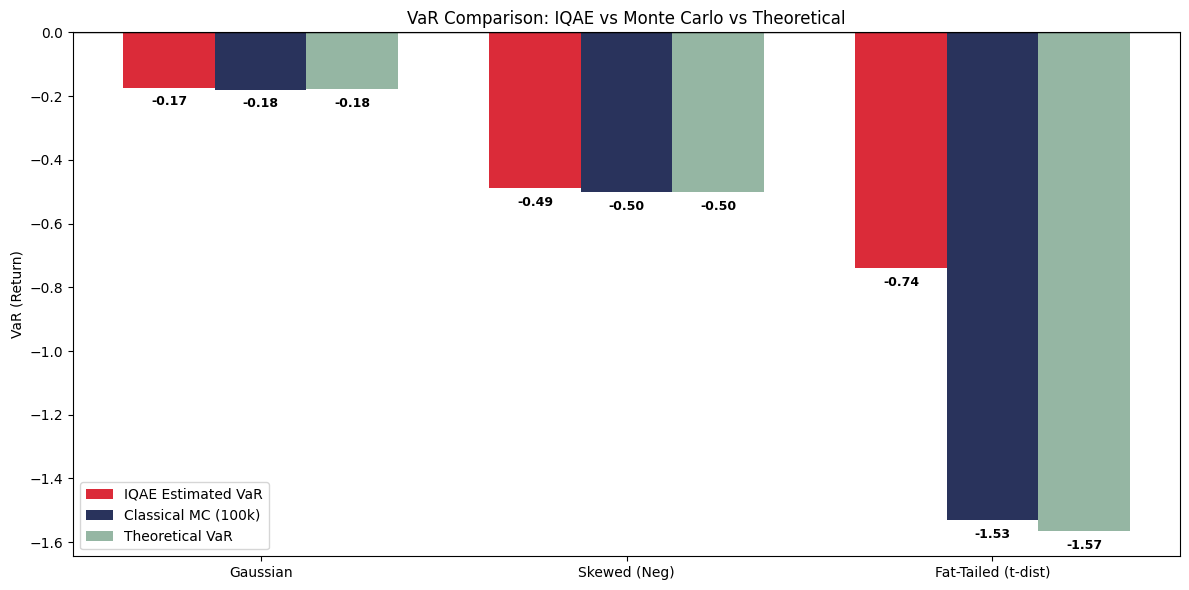

In [98]:
names = list(results.keys())
iqae_vars = [results[n][0] for n in names]
mc_vars = [results[n][1] for n in names]
theory_vars = [results[n][2] for n in names]

x = np.arange(len(names))
width = 0.25  # Thinner bars for 3 groups

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, iqae_vars, width, label='IQAE Estimated VaR', color='#db2b39')
rects2 = ax.bar(x, mc_vars, width, label='Classical MC (100k)', color='#29335c')
rects3 = ax.bar(x + width, theory_vars, width, label='Theoretical VaR', color='#2c6e49', alpha=0.5)

ax.set_ylabel('VaR (Return)')
ax.set_title('VaR Comparison: IQAE vs Monte Carlo vs Theoretical')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -15 if height < 0 else 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', fontweight='bold', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(0, color='black', lw=1)
plt.tight_layout()
plt.show()

**Results Table**

In [99]:
print(f"{'Regime':<20} | {'IQAE VaR':<10} | {'MC VaR':<10} | {'Theory VaR':<10} | {'IQAE Err%':<10} | {'MC Err%':<10}")
print("-"*90)
for name in names:
    v_iqae = results[name][0]
    v_mc = results[name][1]
    v_theo = results[name][2]
    
    err_iqae = (v_iqae - v_theo) / v_theo * 100
    err_mc = (v_mc - v_theo) / v_theo * 100
    
    print(f"{name:<20} | {v_iqae:<10.3f} | {v_mc:<10.3f} | {v_theo:<10.3f} | {err_iqae:<10.2f} | {err_mc:<10.2f}")

Regime               | IQAE VaR   | MC VaR     | Theory VaR | IQAE Err%  | MC Err%   
------------------------------------------------------------------------------------------
Gaussian             | -0.173     | -0.180     | -0.179     | -3.21      | 0.47      
Skewed (Neg)         | -0.488     | -0.501     | -0.502     | -2.75      | -0.15     
Fat-Tailed (t-dist)  | -0.740     | -1.531     | -1.566     | -52.73     | -2.21     
